In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np

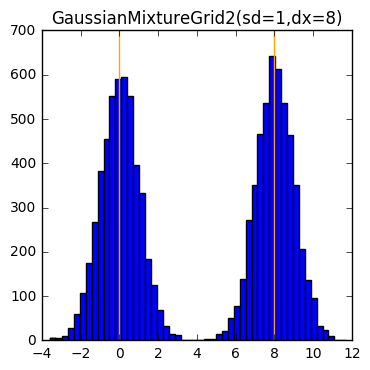

In [2]:
gr1d = GaussianMixtureGrid(2, 1, 8, 1)
plt.figure(figsize=(4,4))
plt.title(gr1d.name)
plt.hist(gr1d.sample(10000), bins=50)
for mu in gr1d.means:
  plt.axvline(mu, c='orange')
plt.show()

In [12]:
s = gr1d.sample(20000)[:,0]

In [13]:
s2 = gr1d.sample(20000)[:,0]

In [14]:
def converged(s, tol=1e-2):
  return np.abs(np.mean(s) - gr1d.means.mean()) < tol

In [15]:
print(converged(s, tol=1e-1))
print(converged(s, tol=1e-3))

True
False


In [47]:
print(convergence_time(s, tol=1e-1))
print(convergence_time(s, tol=5e-2))

11500
-1


In [48]:
convergence_time(np.array([s,s2]), tol=5e-2)

7600

In [8]:
import pymc3 as pm

with pm.Model() as model:
  mix = gr1d.to_pymc()
  trace1 = pm.sample(100000, init=None)

Assigned NUTS to GaussianMixtureGrid2(sd=1,dx=8)
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '74987' (I am process '75227')
100%|██████████| 100000/100000 [00:39<00:00, 2537.77it/s]


In [163]:
values = trace1[gr1d.name]

In [166]:
converged(values, tol=5e-2)

False

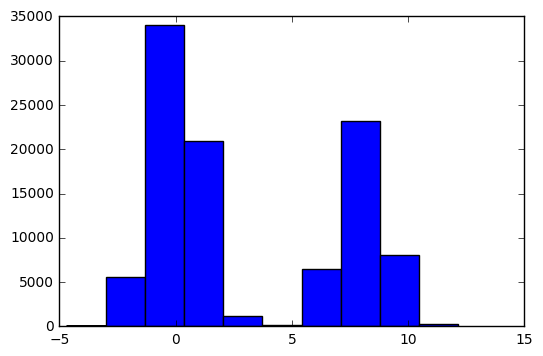

In [167]:
plt.hist(values)
plt.show()

In [61]:
convergence_time(values, tol=0.1)

-1

In [31]:
s3 = gr1d.rejection_sample_bounding_box(50000)

In [32]:
len(s3[1])

17620

In [33]:
s3

(array([[-0.46617007],
        [-0.6171258 ],
        [ 0.03133554],
        ..., 
        [ 7.60646161],
        [ 7.68834774],
        [ 0.27223692]]),
 array([    0,     7,     9, ..., 49981, 49982, 49989]))

In [49]:
convergence_time(s3, tol=0.1)

7944

In [50]:
s4 = gr1d.mh_with_teleportation(
                                initial_value=np.array([4]),
                                proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),
num_samples=25000,
teleprob=0.1)

In [51]:
convergence_time(s4, tol=0.1)

21704.0

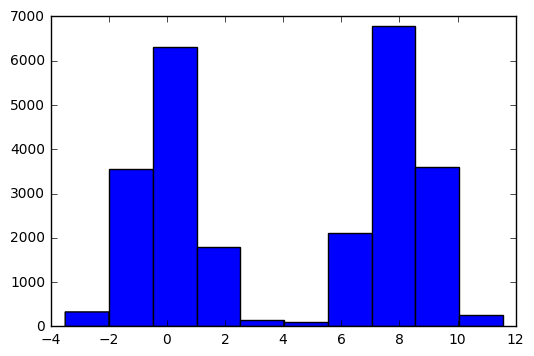

In [39]:
plt.hist(s4)
plt.show()

In [88]:
direct_samples1 = [(gr1d.sample(50000), np.arange(50000)) for _ in range(16)]
direct_samples2 = [(gr1d.sample(50000), np.arange(50000)) for _ in range(16)]
direct_samples3 = [(gr1d.sample(50000), np.arange(50000)) for _ in range(16)]

In [130]:
direct_samples4 = [(gr1d.sample(50000), np.arange(50000)) for _ in range(16)]
direct_samples5 = [(gr1d.sample(50000), np.arange(50000)) for _ in range(16)]

In [156]:
rej_sampls = [gr1d.rejection_sample_bounding_box(100000) for _ in range(16)]

In [143]:
rej_samples2 = [gr1d.rejection_sample_bounding_box(100000) for _ in range(16)]
rej_samples3 = [gr1d.rejection_sample_bounding_box(100000) for _ in range(16)]
rej_samples5 = [gr1d.rejection_sample_bounding_box(100000) for _ in range(16)]

In [157]:
rej_samples4 = [gr1d.rejection_sample_bounding_box(100000) for _ in range(16)]


In [82]:
convergence_time(direct_samples)

5000

In [81]:
convergence_time(rej_sampls)

32300

In [184]:
def convergence_time(chains, tol=5e-2, res=100, conv_after=20, fail_after=5):
  top = max(index[-1] for chain, index in chains)
  i = res
  conv_count = 0
  fail_count = 0
  while i <= top:
    joined = np.vstack(tuple(chain[index <= i] for chain, index in chains))
    if converged(joined, tol):
      conv_count += 1
      if conv_count > conv_after:
        return i - conv_count * res
    else:
      fail_count += 1
      if fail_count > fail_after:
        fail_count = 0
        conv_count = 0
    i += res
  return -1

In [185]:
rej_times1 = np.array([convergence_time(rej_sampls[:i]) for i in [1,2,4,8,16]])
rej_times2 = np.array([convergence_time(rej_samples2[:i]) for i in [1,2,4,8,16]])
rej_times3 = np.array([convergence_time(rej_samples3[:i]) for i in [1,2,4,8,16]])
rej_times4 = np.array([convergence_time(rej_samples4[:i]) for i in [1,2,4,8,16]])
rej_times5 = np.array([convergence_time(rej_samples5[:i]) for i in [1,2,4,8,16]])

In [186]:
rej_times3

array([16800, 13200,  1800,   500,  1000])

In [187]:
rejmean = np.mean([rej_times1,rej_times2,rej_times3,rej_times4,rej_times5],axis=0)
rejsd = np.std([rej_times1,rej_times2,rej_times3,rej_times4,rej_times5],axis=0)

In [188]:
direct_times1 = np.array([convergence_time(direct_samples1[:i]) for i in [1,2,4,8,16]])
direct_times2 = np.array([convergence_time(direct_samples2[:i]) for i in [1,2,4,8,16]])
direct_times3 = np.array([convergence_time(direct_samples3[:i]) for i in [1,2,4,8,16]])
direct_times4 = np.array([convergence_time(direct_samples4[:i]) for i in [1,2,4,8,16]])
direct_times5 = np.array([convergence_time(direct_samples5[:i]) for i in [1,2,4,8,16]])

In [189]:
dirmean = np.mean([direct_times1,direct_times2,direct_times3,direct_times4,direct_times5],axis=0)
dirsd = np.std([direct_times1,direct_times2,direct_times3,direct_times4,direct_times5],axis=0)

array([ -51.61208571,  -47.653306  ,  -43.85777493,  -40.22549251,
        -36.75645874,  -33.45067361,  -30.30813714,  -27.32884931,
        -24.51281013,  -21.8600196 ,  -19.37047771,  -17.04418448,
        -14.88113989,  -12.88134395,  -11.04479666,   -9.37149802,
         -7.86144802,   -6.51464668,   -5.33109398,   -4.31078993,
         -3.45373453,   -2.75992777,   -2.22936966,   -1.86206021,
         -1.6579994 ,   -1.61718723,   -1.73962372,   -2.02530885,
         -2.47424264,   -3.08642506,   -3.86185585,   -4.80052835,
         -5.90227373,   -7.16282494,   -8.48065757,   -8.77682156,
         -7.56637623,   -6.26437389,   -5.11395345,   -4.12631817,
         -3.30191325,   -2.64075626,   -2.14284788,   -1.80818815,
         -1.63677707,   -1.62861464,   -1.78370086,   -2.10203572,
         -2.58361923,   -3.22845139,   -4.0365322 ,   -5.00786165,
         -6.14243976,   -7.44026651,   -8.90134191,  -10.52566596,
        -12.31323866,  -14.26406   ,  -16.37812999,  -18.65544

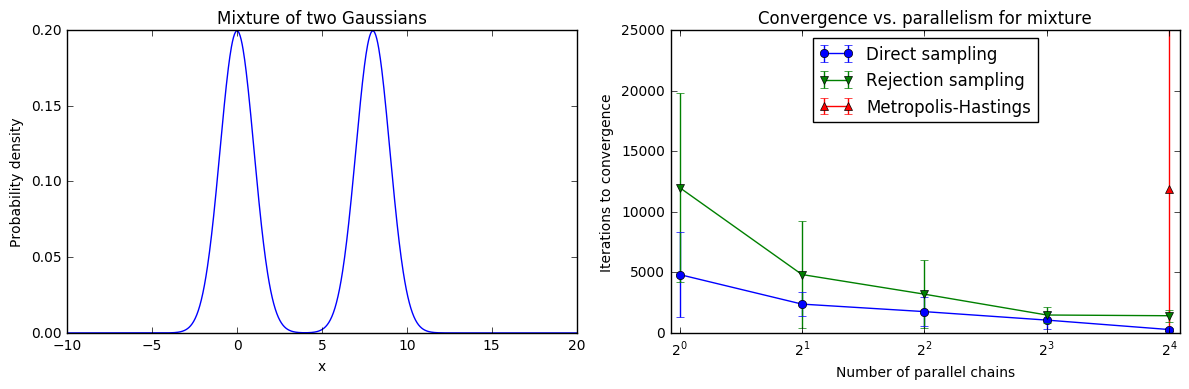

In [233]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Mixture of two Gaussians')
plt.plot(np.linspace(-10,20,1000),np.exp(gr1d.logps(np.array([np.linspace(-10,20,1000)]).T)))
plt.xlabel('x')
plt.ylabel('Probability density')
plt.subplot(122)
plt.errorbar(np.array([1,2,4,8,16]),dirmean,yerr=dirsd,marker='o',label='Direct sampling')
plt.errorbar(np.array([1,2,4,8,16]),rejmean,yerr=rejsd,marker='v',label='Rejection sampling')
plt.errorbar(np.array([16]),mhmean[-2:-1],yerr=mhsd[-2:-1],marker='^',label='Metropolis-Hastings')
plt.legend(loc='upper center')
plt.xscale('log', basex=2)
plt.xlim(0.95, 17)
plt.xlabel('Number of parallel chains')
plt.ylabel('Iterations to convergence')
plt.title('Convergence vs. parallelism for mixture')
plt.ylim(0,25000)
plt.tight_layout()
plt.show()

In [167]:
mh1 = [gr1d.mh_with_teleportation(initial_value=np.array([4]),proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),num_samples=50000,teleprob=0) for _ in range(16)]
mh2 = [gr1d.mh_with_teleportation(initial_value=np.array([4]),proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),num_samples=50000,teleprob=0) for _ in range(16)]
mh3 = [gr1d.mh_with_teleportation(initial_value=np.array([4]),proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),num_samples=50000,teleprob=0) for _ in range(16)]
mh4 = [gr1d.mh_with_teleportation(initial_value=np.array([4]),proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),num_samples=50000,teleprob=0) for _ in range(16)]
mh5 = [gr1d.mh_with_teleportation(initial_value=np.array([4]),proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),num_samples=50000,teleprob=0) for _ in range(16)]

In [191]:
mh_times1 = np.array([convergence_time(mh1[:i]) for i in [1,2,4,8,16]])
mh_times2 = np.array([convergence_time(mh2[:i]) for i in [1,2,4,8,16]])
mh_times3 = np.array([convergence_time(mh3[:i]) for i in [1,2,4,8,16]])
mh_times4 = np.array([convergence_time(mh4[:i]) for i in [1,2,4,8,16]])
mh_times5 = np.array([convergence_time(mh5[:i]) for i in [1,2,4,8,16]])
mhmean = np.mean([mh_times1,mh_times2,mh_times3,mh_times4,mh_times5],axis=0)
mhsd = np.std([mh_times1,mh_times2,mh_times3,mh_times4,mh_times5],axis=0)

In [211]:
mh_times1

array([   -1,    -1,  5200,    -1, 17800])

In [212]:
mhmean = np.mean([mh_times1,mh_times3,mh_times4,mh_times5],axis=0)
mhsd = np.std([mh_times1,mh_times3,mh_times4,mh_times5],axis=0)

In [248]:
eff1 = GaussianMixtureGrid(2, 1, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff2 = GaussianMixtureGrid(2, 2, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff3 = GaussianMixtureGrid(2, 3, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff4 = GaussianMixtureGrid(2, 4, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff5 = GaussianMixtureGrid(2, 5, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff6 = GaussianMixtureGrid(2, 6, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff7 = GaussianMixtureGrid(2, 7, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.
eff8 = GaussianMixtureGrid(2, 8, 1, 1).rejection_sample_bounding_box(10000)[0].size/10000.

eff8

0.012

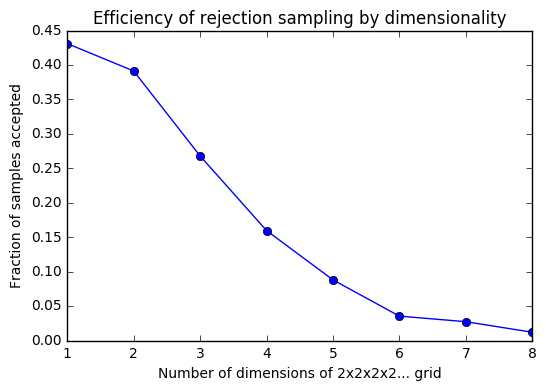

In [254]:
plt.plot(np.arange(1,9),[eff1,eff2,eff3,eff4,eff5,eff6,eff7,eff8],marker='o')
plt.xlabel('Number of dimensions of 2x2x2x2... grid')
plt.ylabel('Fraction of samples accepted')
plt.title('Efficiency of rejection sampling by dimensionality')
plt.show()